In [2]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
DATA_DIR      = "../datasets"
OUT_DIR       = "../datasets/merged"
OUT_FILE      = f"{OUT_DIR}/master_improved.csv"
START_DATE    = "2014-09-17"
END_DATE      = "2025-06-15"

os.makedirs(OUT_DIR, exist_ok=True)

Consolidar archivos de activos e índices con los datos de Bitcoin:

In [4]:
def load_price_data(folder, prefix, col_name):
    files = sorted(glob(f'{DATA_DIR}/{folder}/{prefix}_*.csv'))
    if not files:
        print(f"⚠️ No se encontraron archivos en ./datasets/{folder}/{prefix}_*.csv")
        return pd.DataFrame()

    dfs = []
    for f in files:
        # Leer las tres primeras filas manualmente
        with open(f, 'r') as file:
            header1 = next(file).strip().split(',')
            header2 = next(file).strip().split(',')
            header3 = next(file).strip().split(',')

        # Combinar headers (ej: "Close BTC-USD")
        combined_header = [f"{h1} {h2}".strip() for h1, h2 in zip(header1, header2)]

        # Ahora leer el resto del archivo
        df = pd.read_csv(f, skiprows=3, names=combined_header)

        # Parsear la columna de fecha
        date_col = combined_header[0]  # normalmente "Price Ticker Date"
        df = df.rename(columns={date_col: "Date"})
        df['Date'] = pd.to_datetime(df['Date'])

        # Tomar solo la columna de interés (ej: "Close BTC-USD")
        price_col = [col for col in df.columns if col.startswith("Close")][0]
        df = df[['Date', price_col]].rename(columns={price_col: col_name})
        dfs.append(df)

    return pd.concat(dfs).drop_duplicates('Date').set_index('Date').sort_index()

In [5]:
def load_yearly_csv(folder, col_name):
    files = sorted(glob(f'{DATA_DIR}/{folder}/*.csv'))
    dfs = []
    for f in files:
        df = pd.read_csv(f, parse_dates=['date'])
        df = df.rename(columns={'date': 'Date', df.columns[1]: col_name})
        dfs.append(df)
    return pd.concat(dfs).drop_duplicates('Date').set_index('Date').sort_index()

In [6]:
def load_fear_index():
    df = pd.read_csv(f'{DATA_DIR}/fear_and_greed_index/fear_and_greed_index.csv', parse_dates=['timestamp'])
    df = df[['timestamp', 'value']].rename(columns={'timestamp': 'Date', 'value': 'fear_greed'})
    return df.drop_duplicates('Date').set_index('Date').sort_index()

In [7]:
def load_trend():
    files = sorted(glob(f'{DATA_DIR}/trend/bitcoin_trend_*.csv'))
    dfs = []
    for f in files:
        df = pd.read_csv(f, parse_dates=['date'])
        df = df.rename(columns={'date': 'Date', 'bitcoin': 'trend'})
        dfs.append(df)
    return pd.concat(dfs).drop_duplicates('Date').set_index('Date').sort_index()

In [8]:
def align_series(
    s: pd.Series,
    date_range: pd.DatetimeIndex,
    carry_last_before_start: bool = True,
) -> pd.Series:
    """
    Devuelve la serie `s` reindexada a `date_range`.

    Si `carry_last_before_start=True`, propaga hacia adelante el último valor
    válido anterior a START_DATE; de lo contrario deja NaN hasta el primer dato.
    """
    idx_union = s.index.union(date_range)           # 1) unir índices
    if carry_last_before_start:
        s = s.reindex(idx_union).ffill()            # 2) ffill dentro de la serie
    else:
        s = s.reindex(idx_union)                    #   (mantiene NaN)
    return s.reindex(date_range)                    # 3) recorta al rango final


In [9]:
date_range = pd.date_range(start=START_DATE, end=END_DATE, freq='D')

# DataFrame base con todas las fechas
merged_df = pd.DataFrame(index=date_range)

# Cargar datasets
# BTC
merged_df = merged_df.join(load_price_data('btc', 'btc', 'btc_close'))

# Active Addresses (propagar valor previo)
active_raw = load_yearly_csv("active_addresses", "active_addresses")
active     = align_series(active_raw["active_addresses"], date_range, True)
merged_df = merged_df.join(active)

# DXY (propagar valor previo)
dxy_raw = load_price_data("dxy", "dxy", "dxy_close")
dxy     = align_series(dxy_raw["dxy_close"], date_range, True)
merged_df = merged_df.join(dxy)

# ETH (no propagar hacia atrás)
eth_raw = load_price_data("eth", "eth", "eth_close")
eth     = align_series(eth_raw["eth_close"], date_range, False)
merged_df = merged_df.join(eth)

# Fear & Greed (no propagar hacia atrás)
fg_raw = load_fear_index()
fg     = align_series(fg_raw["fear_greed"], date_range, False)
merged_df = merged_df.join(fg)

# Gold (propagar valor previo)
gold_raw = load_price_data("gold", "gold", "gold_close")
gold     = align_series(gold_raw["gold_close"], date_range, True)
merged_df = merged_df.join(gold)

# Interest Rate (propagar valor previo)
interest_raw = load_yearly_csv("interest_rate", "interest_rate")
interest     = align_series(interest_raw["interest_rate"], date_range, True)
merged_df = merged_df.join(interest)

# S&P 500 (propagar valor previo)
sp_raw = load_price_data("sp500", "sp500", "sp500_close")
sp     = align_series(sp_raw["sp500_close"], date_range, True)
merged_df = merged_df.join(sp)

# Google Trends (propagar valor previo)
trend_raw = load_trend()
trend     = align_series(trend_raw["trend"], date_range, True)
merged_df = merged_df.join(trend)

# Reindexar y rellenar
merged_df = merged_df.sort_index().reindex(date_range)
# Relleno temporal solo entre huecos internos
merged_df = merged_df.interpolate(
    method="time",
    limit_direction="both",
    limit_area="inside"
)

# Adelante/atrás solo dentro de los bloques válidos
merged_df = merged_df.ffill(limit_area="inside").bfill(limit_area="inside")

# Guardar CSV
merged_df.to_csv(f'{OUT_FILE}')
print("✔️ Archivo consolidado generado")

merged_df

✔️ Archivo consolidado generado


,btc_close,active_addresses,dxy_close,eth_close,fear_greed,gold_close,interest_rate,sp500_close,trend
2014-09-17,457.334015,160989.0,84.699997,NaN,NaN,1234.400024,0.09,2001.569946,22.0
2014-09-18,424.440002,160989.0,84.320000,NaN,NaN,1225.699951,0.09,2011.359985,22.0
2014-09-19,394.795990,143062.0,84.800003,NaN,NaN,1215.300049,0.09,2010.400024,22.0
2014-09-20,408.903992,143062.0,84.800003,NaN,NaN,1215.300049,0.09,2010.400024,22.0
2014-09-21,398.821014,143062.0,84.800003,NaN,NaN,1215.300049,0.09,2010.400024,22.0
...,...,...,...,...,...,...,...,...,...
2025-06-11,108686.625000,506842.0,98.629997,2773.529297,72.0,3321.300049,4.33,6022.240234,35.0
2025-06-12,105929.054688,506842.0,97.919998,2651.795166,71.0,3380.899902,4.33,6045.259766,35.0
2025-06-13,106090.968750,506842.0,98.138000,2579.486084,61.0,3452.600098,4.33,5976.970215,35.0
2025-06-14,105472.406250,506842.0,98.138000,2533.444092,63.0,3452.600098,4.33,5976.970215,35.0


In [10]:
merged_df.index = pd.to_datetime(merged_df.index)
merged_df = merged_df.sort_index()
numeric_cols = merged_df.select_dtypes(include='number').columns.tolist()

# Verificar si hay valores faltantes
faltantes = merged_df[numeric_cols].isnull().sum()
if (faltantes > 0).any():
    print("Valores faltantes por columna:\n" + faltantes[faltantes > 0].to_string())
else:
    print("✅ No hay valores faltantes en las columnas numéricas.")

Valores faltantes por columna:
eth_close     1149
fear_greed    1233


Calcularemos el retorno logarítmico para BTC. De esta forma suavizaremos las variaciones intentando generar estacionaridad 

El delta elegido para este valor será de 1 día. Es decir calcularemos la diferencia entre cierres de btc entre días.  

r =log(Pt)−log(Pt−n)

También calcularemos RSI con un período de 14 días

In [15]:
# Asegurarse de que la columna btc_close exista
if 'btc_close' not in merged_df.columns:
    raise ValueError("La columna 'btc_close' no está presente en el DataFrame.")

# 1. Retorno logarítmico diario de BTC
merged_df['btc_log_return'] = np.log(merged_df['btc_close'] / merged_df['btc_close'].shift(1))
merged_df['active_addresses_pct_change'] = merged_df['active_addresses'].pct_change()
merged_df['trend_diff'] = merged_df['trend'].diff()

# 2. RSI de 14 días
def calcular_RSI(series, window=14):
    delta = series.diff()
    ganancia = delta.clip(lower=0)
    perdida = -delta.clip(upper=0)

    media_ganancia = ganancia.rolling(window=window).mean()
    media_perdida = perdida.rolling(window=window).mean()

    rs = media_ganancia / media_perdida
    rsi = 100 - (100 / (1 + rs))
    return rsi

merged_df['btc_rsi'] = calcular_RSI(merged_df['btc_close'], window=14)

# 3. Retornos logarítmicos de otros activos
asset_cols = {
    'eth_close': 'eth_log_return',
    'sp500_close': 'sp500_log_return',
    'gold_close': 'gold_log_return',
    'dxy_close': 'dxy_log_return'
}

for col, ret_col in asset_cols.items():
    if col in merged_df.columns:
        merged_df[ret_col] = np.log(merged_df[col] / merged_df[col].shift(1))
    else:
        print(f"⚠️ Advertencia: '{col}' no encontrado en el DataFrame.")

# 4. Guardar
merged_df.to_csv(f'{OUT_FILE}')
df = merged_df
print("✔️ Archivo con RSI, retornos logarítmicos y variaciones porcentuales guardado en:", OUT_FILE)

✔️ Archivo con RSI, retornos logarítmicos y variaciones porcentuales guardado en: ../datasets/merged/master_improved.csv


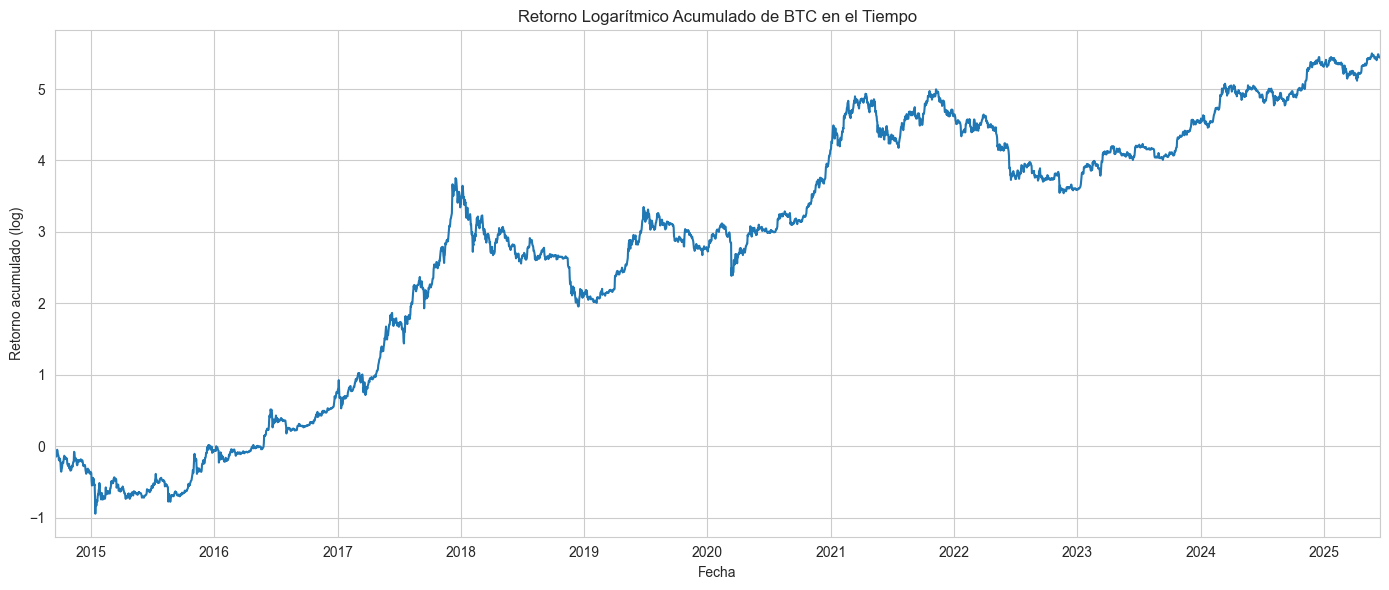

In [14]:
# Calcular el retorno logarítmico acumulado
df['btc_log_cumsum'] = df['btc_log_return'].cumsum()

# Graficar
plt.figure(figsize=(14, 6))
df['btc_log_cumsum'].plot()
plt.title('Retorno Logarítmico Acumulado de BTC en el Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Retorno acumulado (log)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
df

,btc_close,active_addresses,dxy_close,eth_close,fear_greed,gold_close,interest_rate,sp500_close,trend,btc_log_return,btc_rsi,eth_log_return,sp500_log_return,gold_log_return,dxy_log_return,btc_log_cumsum,active_addresses_pct_change,trend_diff
2014-09-17,457.334015,160989.0,84.699997,NaN,NaN,1234.400024,0.09,2001.569946,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,160989.0,84.320000,NaN,NaN,1225.699951,0.09,2011.359985,22.0,-0.074643,NaN,NaN,0.004879,-0.007073,-0.004496,-0.074643,0.000000,0.0
2014-09-19,394.795990,143062.0,84.800003,NaN,NaN,1215.300049,0.09,2010.400024,22.0,-0.072402,NaN,NaN,-0.000477,-0.008521,0.005676,-0.147045,-0.111355,0.0
2014-09-20,408.903992,143062.0,84.800003,NaN,NaN,1215.300049,0.09,2010.400024,22.0,0.035111,NaN,NaN,0.000000,0.000000,0.000000,-0.111934,0.000000,0.0
2014-09-21,398.821014,143062.0,84.800003,NaN,NaN,1215.300049,0.09,2010.400024,22.0,-0.024968,NaN,NaN,0.000000,0.000000,0.000000,-0.136901,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-11,108686.625000,506842.0,98.629997,2773.529297,72.0,3321.300049,4.33,6022.240234,35.0,-0.014347,52.176150,-0.014315,-0.002748,0.000120,-0.004249,5.470810,0.000000,0.0
2025-06-12,105929.054688,506842.0,97.919998,2651.795166,71.0,3380.899902,4.33,6045.259766,35.0,-0.025699,50.686823,-0.044884,0.003815,0.017786,-0.007225,5.445111,0.000000,0.0
2025-06-13,106090.968750,506842.0,98.138000,2579.486084,61.0,3452.600098,4.33,5976.970215,35.0,0.001527,55.383442,-0.027647,-0.011361,0.020986,0.002224,5.446638,0.000000,0.0
2025-06-14,105472.406250,506842.0,98.138000,2533.444092,63.0,3452.600098,4.33,5976.970215,35.0,-0.005848,52.148885,-0.018011,0.000000,0.000000,0.000000,5.440791,0.000000,0.0
